In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import imageio
from smpl_torch import SMPLModel
from enum import Enum
import cv2
import torch.nn as nn

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)

from torch_openpose.body import Body
from torch_openpose import util

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# add path for demo utils functions 
import sys
import os
import copy
sys.path.append(os.path.abspath(''))

In [30]:
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer):
    R, T = look_at_view_transform(2.0, 10, 0) 
    T[0, 1] = 0.3
    images = renderer(cur_mesh, R=R.cuda(), T=T.cuda())
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)


class Model(nn.Module):
    def __init__(self, target_paf, target_heat, renderer, body_estimation):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.body_estimation = body_estimation
        self.smpl_model = SMPLModel(device=self.device)
        
        self.cur_mesh = None
        pose_size = 72
        beta_size = 10
        
        self.pose_params = nn.Parameter(
            torch.from_numpy(np.zeros(pose_size)).to(self.device)
        )
        
        self.betas = torch.from_numpy(
            (np.random.rand(beta_size) - 0.5) * 0.000).type(torch.float64).to(self.device)
            
        self.trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)
        
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        #self.objective = torch.nn.L1Loss()
        
        self.verts_uvs = torch.from_numpy(np.load('uv_table.npy')).float().unsqueeze(0).cuda()
        self.maps = torch.from_numpy(
            cv2.cvtColor(cv2.imread("tex.png", cv2.IMREAD_COLOR),  cv2.COLOR_BGR2RGB) / 255
        ).unsqueeze(0).float().cuda()
        
        self.target_paf = target_paf
        self.target_heat = target_heat
    
    def forward(self):
        # compute the verticies from the smpl model
        vertices = self.smpl_model(self.betas, self.pose_params, self.trans)
        
        
        verticies = vertices.unsqueeze(0).float()
        faces = torch.from_numpy(self.smpl_model.faces.astype(np.long)).unsqueeze(0).cuda()

        faces_uvs = faces.clone()
        
        textures = Textures(self.maps, faces_uvs, self.verts_uvs)
        self.cur_mesh = Meshes(verticies, faces, textures)
    
        images = self.renderer(self.cur_mesh)
        
        #
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.target_heat)
        ob_val_paf = self.objective(paf, self.target_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, images

In [31]:
# Setup
ORIG_SHAPE = (512, 512, 3)
device = torch.device("cuda:0")
torch.cuda.set_device(device)
body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]
R, T = look_at_view_transform(2.0, 10, 0) 
T[0, 1] = 0.3
cameras = OpenGLPerspectiveCameras(device=device, R=R.cuda(), T=T.cuda())

raster_settings = RasterizationSettings(
    image_size=ORIG_SHAPE[0], 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [32]:
# load target
target_image = cv2.imread('../data/images/dri_target_512.jpg', cv2.IMREAD_COLOR)
data = body_estimation.image_to_input_tensor(target_image, False).cuda()

target_paf, target_heat = body_estimation.model(data)
candidate, subset = body_estimation(target_image)
canvas = copy.deepcopy(target_image)
canvas = util.draw_bodypose(canvas, candidate, subset)

In [33]:
model = Model(
    target_heat=target_heat,
    target_paf=target_paf,
    renderer=renderer,
    body_estimation=body_estimation
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
filename_output = "./smpl_pose_opt_dir.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
losses = []
for i in tqdm(range(100)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.item())
    #wandb.log({'loss': loss.item()}, step=i)
    
    # Save outputs to create a GIF. 
    image = cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = np.clip(image, -1, 1)
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

100%|██████████| 100/100 [01:29<00:00,  1.11it/s]


![SegmentLocal](smpl_pose_opt_dir.gif "segment")

In [28]:
canvas_result, *_ = get_body_image_from_mesh(model.cur_mesh, body_estimation, renderer)

Text(0.5, 1.0, 'Result Pose')

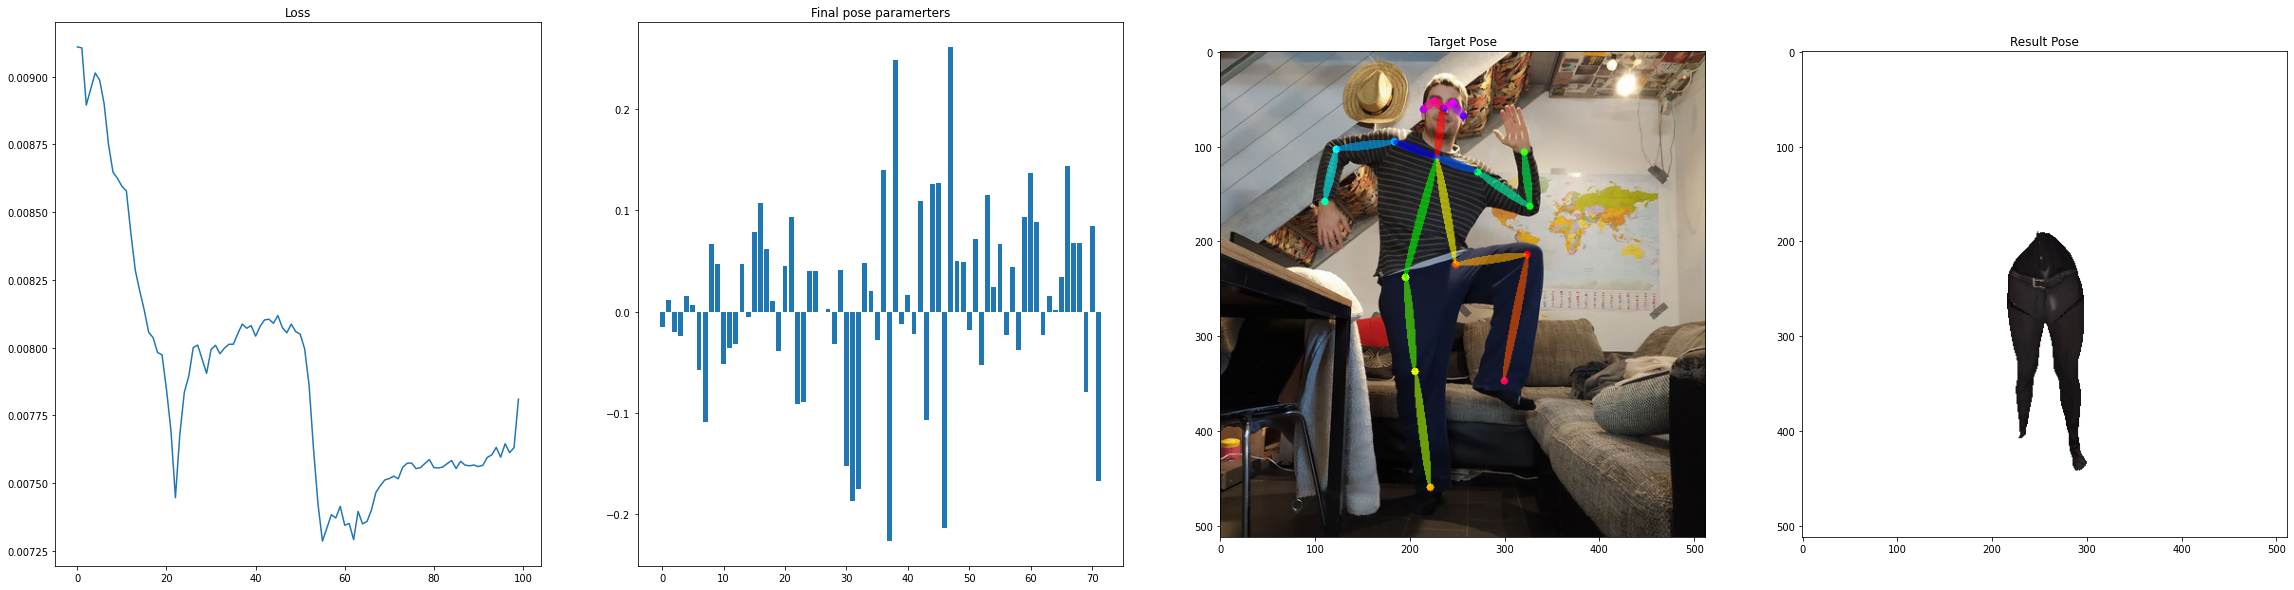

In [36]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(1, 4, 1)
ax.plot(losses)
ax.set_title(f"Loss")

ax = fig.add_subplot(1, 4, 2)
y =  model.pose_params.detach().cpu().numpy()
x = range(len(y))
ax.bar(x, y)
ax.set_title(f"Final pose paramerters")


ax = fig.add_subplot(1, 4, 3)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.set_title(f"Target Pose")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(canvas_result)
ax.set_title(f"Result Pose")